# Stima dell'efficacia di un vaccino

La stima dell'efficacia di un vaccino è argomento di grande attualità. Il 30/12/2020 è stata pubblicata l'analisi dell'efficacia del vaccino della Pfitzer contro il Sars-Cov-2 in [N Engl J Med 2020; 383:2603-2615](https://www.nejm.org/doi/full/10.1056/NEJMoa2034577). Il 2/2/2021 è stata pubblicata l'analisi dell'efficacia del vaccino Sputnik V in [Lancet 2021; 397: 671–81](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(21)00234-8/fulltext)

Nel seguito vediamo un metodo semplificato ma corretto per la determinazione dell'efficacia da un capione di persone vaccinate ed un campione di persone che hanno ricevuto un placebo.

In generale, si inietta il vaccino ad $N_1$ persone ed un placebo ad $N_0$ persone e si monitora, nel tempo, quante persone si infettano nei due campioni. Dopo un tempo inziale in cui il vaccino non è ancora efficace, il tasso di infezioni dovrebbe diminuire nel campione vaccinato rispetto al campione che ha ricevuto il placebo. Le persone che partecipano al test non sanno se hanno ricevuto vaccino o placebo, così che non ci sia alcuna informazione che induca differenti stili di vita che potrebbero modificare la probabilità di infettarsi.

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.optimize
from scipy.stats import binom
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import patches

## Tasso di contagio in assenza di vaccino

Se sappiamo di avere in Italia circa $15\,000$ infettti al giorni su 60 milioni di abitanti (situazione Covid19  nel 2021), circa, possiamo calcolare la **probabilità di infettersi in $n$ giorni per una persona non vaccinata**, come segue.

La probabilità di **non** infettarsi in un giorno è $1-p_{0,1\mathrm{g}}$. L'eventuale infezione in ciascun giorno è indipendente da un'eventuale infezione in un altro giorno, quindi la probabilità di **non** infettarsi in nessuno degli $n$ giorni è $(1-p_{0,1\mathrm{g}})^n$. Abbiamo assunto che la probabiltià di infettarsi non varia nei giorni considerati. La probabilità di infettarsi in $n$ giorni, quindi è il complemento:

$p_0 = 1-(1-p_{0,1\mathrm{g}})^n \simeq n\cdot p_{0,1\mathrm{g}}$ se $p_{0,1\mathrm{g}}\ll 1$. 

Il pedice "0" sta per "non vaccinato". Useremo "1" per vaccinato.

dove $p_{0,1\mathrm{g}}$ è la probabilità di infettarsi in un giorno per una persona che non si è vaccianta.
Useremo $n=30$ giorni, che è un tempo tipico per questi test.

In [4]:
p1g = 15000/60000000 # in Italia 15.000 casi su 60M di abitanti al giorno
ng = 30
p0 = 1 - math.pow(1 - p1g, ng)
print('p(1g): {:.4%}'.format(p1g))
print('p0: {:.4%}'.format(p0))
# stima approssimata pià semplice
p0_1 = p1g*ng
print('p0[*]: {:.4%}'.format(p0_1))

p(1g): 0.0250%
p0: 0.7473%
p0[*]: 0.7500%


Assumendo un'efficacia $\varepsilon$ possiamo calcolare la **probabilità di infettarsi entro $n$ giorni per un vaccinato** come:

$p_1 = p_0\,(1-\varepsilon)$

Assumiamo un'efficacia $\varepsilon$ del 90% per generare un campione simulato.

In [5]:
eff = 0.9
p1 = p0*(1 - eff)

## Campioni di test e di controllo

Supponiamo di avere $N_0$ persone non vaccinate (es.: vaccinate con un *placebo*) e $N_1$ persone vaccinate. 

Si può calcolare quanti casi di infezioni $I_1$ e $I_0$ ci si aspetta tra vaccinati e tra non vaccinati nel periodo di osservazione di $n$ giorni:

$\mathbb{E}[{I_0}] = p_0\, N_0$

$\mathbb{E}[{I_1}] = p_1\, N_1 = p_0\,(1-\varepsilon)\,N_1$

Assumiamo $N_0 = N_1 = 10\,000$, numeri tipici per questo tipo di test.

In [6]:
n0, n1 = 10000, 10000
i0_exp = p0*n0
i1_exp = p1*n1
print('Expected no vax: E[i0] = {:.3f}'.format(i0_exp))
print('Expected vax   : E[i1] = {:.3f}'.format(i1_exp))

Expected no vax: E[i0] = 74.729
Expected vax   : E[i1] = 7.473


La distribuzione del numero di casi osservati nelle due categorie seguirà una distribuzione biomiale con valori attesi indicati sopra. La binomiale in queste condizioni potrebbe essere approssimata con una poissoniana.

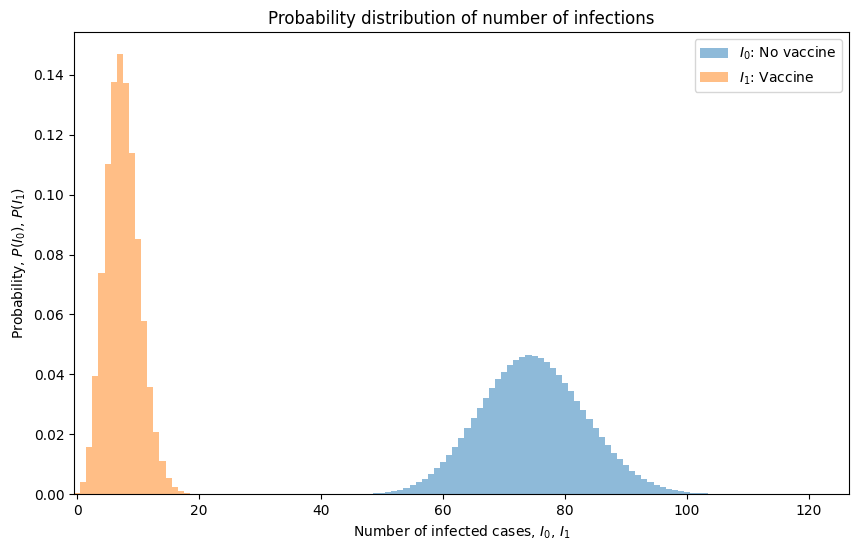

In [7]:
i_range = np.linspace(0, 120, 121)
pmf0 = binom.pmf(i_range, n0, p0)
pmf1 = binom.pmf(i_range, n1, p1)
plt.figure(figsize=(10, 6))
plt.bar(i_range, pmf0, width=1, label='$I_0$: No vaccine', alpha=0.5)
plt.bar(i_range, pmf1, width=1, label='$I_1$: Vaccine', alpha=0.5)
plt.title("Probability distribution of number of infections")
plt.xlabel("Number of infected cases, $I_0$, $I_1$")
plt.ylabel("Probability, $P(I_0)$, $P(I_1)$")
plt.xlim(-0.5)
#plt.yscale('log')
plt.legend()
plt.show()

Definiamo la funzione di verosimiglianza dell'osservazione simultanea del numero di infetti osservati nei due campioni, $I_0$ e $I_1$, come il prodotto di due binomiali con probabilità che dipendono dal valore di efficienza che viene assunto.

Supponiamo di avere un certo numero di casi osservati, $I_0$ e $I_1$, come segue:

In [8]:
# test values
i0, i1 = 75, 11

## Stima di $p_0$ e $p_1$

Immaginiamo di stimare indipendentemente $p_0$ e $p_1$. Possiamo determinare la stima di massima verosimiglianza ponendo a zero la derivata della funzione binomiale rispetto al parametro da stimare:

$\displaystyle \left.\frac{\partial\,{\mathrm{Bin}}(n_0; p_0, N_0)}{\partial p_0}\right|_{n_0=I_0} = 0$

e si ottiene:
    
$\displaystyle \widehat{p}_0 = r_0 = \frac{I_0}{N_0}$

Analogamente, per $p_1$ avremo:

$\displaystyle \widehat{p}_1 = r_1 = \frac{I_1}{N_1}$

Da cui, considerando che la stima di massima verosimiglianza è invariante per la riparametrizzazione $(p_0, p_1)\rightarrow(\varepsilon = 1 - p_1/p_0, p_0)$, la cui inversa è $(\varepsilon, p_0) \rightarrow (p_0, p_1=p_0(1-\varepsilon))$:

$\displaystyle \widehat{p}_1 = \widehat{p}_0(1-\widehat{\varepsilon})$


$\displaystyle \widehat{\varepsilon} = 1 - \frac{\widehat{p}_1}{\widehat{p}_0} = 1 - \frac{r_1}{r_0}$

Il rapporto $\widehat{p}_1/\widehat{p}_0$ viene anche detto *risk ratio*.

Da notare che, mentre $I_0$ e $I_1$ sono indipendenti, c'è necessariamente correlazione tra le stime $\widehat{p}_0$ e $\widehat{\varepsilon}$ perché c'è una relazione non lineare che lega un parametro all'altro.

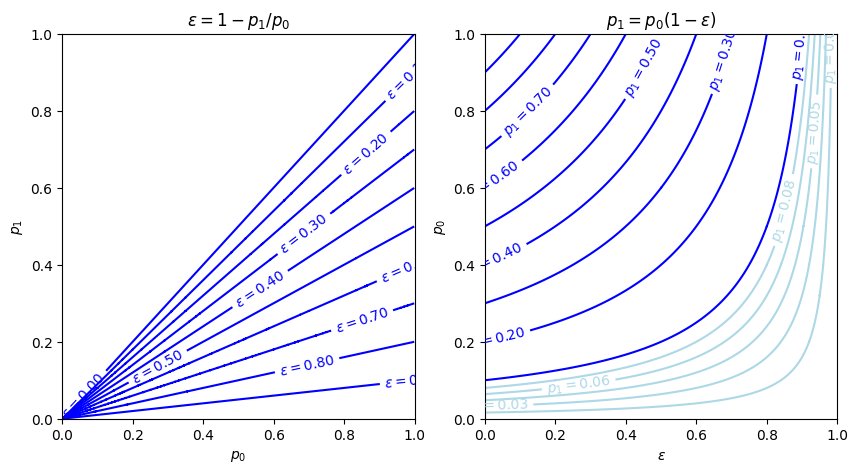

In [10]:
nptx, npty = 999, 999
x_p = np.linspace(0.001, 0.999, nptx)
y_p = np.linspace(0.001, 0.999, npty)
x, y = np.meshgrid(x_p, y_p)
f = lambda p0, p1: 1 - p1/p0 
z = f(x, y)
figure, ax = plt.subplots(1, 2, figsize=(10, 5))
con = ax[0].contour(x, y, z, np.linspace(0, 1, 11), colors='blue')
ax[0].clabel(con, con.levels, fmt=lambda x: r"$\varepsilon = ${:.2f}".format(x), fontsize=10)
ax[0].set_title(r'$\varepsilon = 1 - p_1/p_0$')
ax[0].set_xlabel(r"$p_0$")
ax[0].set_ylabel(r'$p_1$')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
f = lambda e, p0: p0*(1 - e) 
z = f(x, y)
con = ax[1].contour(x, y, z, np.linspace(0, 1, 11), colors='blue')
ax[1].clabel(con, con.levels, fmt=lambda x: r"$p_1 = ${:.2f}".format(x), fontsize=10)
con1 = ax[1].contour(x, y, z, np.linspace(0, 0.08, 6), colors='lightblue')
ax[1].clabel(con1, con1.levels, fmt=lambda x: r"$p_1 = ${:.2f}".format(x), fontsize=10)
ax[1].set_title(r'$p_1 = p_0(1-\varepsilon)$')
ax[1].set_xlabel(r"$\varepsilon$")
ax[1].set_ylabel(r'$p_0$')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
plt.show()

In [11]:
p0_est, p1_est = i0/n0, i1/n1
eff_est = 1.0 - p1_est/p0_est
print('** Summary **')
print('no vax  : N0 =', n0, 'I0 =', i0, 'p0 = {:.5f}'.format(p0))
print('vax     : N1 =', n1, 'I1 =', i1, 'p1 = {:.5f}'.format(p1))
print('efficacy: p0 est. = {:.5f}'.format(p0_est))
print('efficacy: p1 est. = {:.5f}'.format(p1_est))
print('efficacy: ε est. = {:.5f}'.format(eff_est))

** Summary **
no vax  : N0 = 10000 I0 = 75 p0 = 0.00747
vax     : N1 = 10000 I1 = 11 p1 = 0.00075
efficacy: p0 est. = 0.00750
efficacy: p1 est. = 0.00110
efficacy: ε est. = 0.85333


## Stima di massima verosimiglianza

Possiamo definire la funzione di verosimiglianza come prodotto di due PDF binomiali, una per ciascun campione. 

La funzione di verosimiglianza dipenderà da:
* I valori osservati $I_0$, $I_1$
* l'efficacia del vaccino $\varepsilon$
* la probabilità di infezione senza vaccino $p_0$
* il numero di persone non vaccinate e vaccinate, $N_0$ e $N_1$

${\cal L} = p(I_0, I_1; \varepsilon, p_0, N_0, N_1) = {\mathrm{Bin}}(I_0; p_0, N_0)\cdot {\mathrm{Bin}}(I_1; (1-\varepsilon)\,p_0, N_1)$

Si può risolvere il sistema che si ottiene ponendo a zero le derivate di $\log{\cal L}$ rispetto a $p_0$ ed $\varepsilon$. I risultati sono identici a quanto ricavato sopra grazie all'invarianza per riparametrizzazione della stima di massima verosimiglianza. Vedremo, invece, che per la determinazione degli errori la parametrizzazione avrà un ruolo importante.

In [12]:
def likelihood(i0, i1, eff, p0, n0, n1):
    pmf0 = binom.pmf(i0, n0, p0)
    p1 = p0*max(0.0001, 1 - eff)
    pmf1 = binom.pmf(i1, n1, p1)
    lik = pmf0 * pmf1
    return lik

Definiamo una funzione che restituisca $-2\log{\cal L}$ che va minimizzata:

In [14]:
def neg_2log_likelihood(i0, i1, eff, p0, n0, n1):
    return -2*math.log(likelihood(i0, i1, eff, p0, n0, n1))

Definiamo una funzione che calcola numericamente il valore minimo a partire da una coppia di valori inziali ```init```. Verificheremo che il valore ottenuto coincide con il calcolo analitici, come *sanity check*:

In [15]:
def max_likelihood(i0, i1, n0, n1, init):
    xopt, fopt, niter, funcalls, warnflag = scipy.optimize.fmin(lambda args:
        neg_2log_likelihood(i0, i1, args[0], args[1], n0, n1), init,
        full_output=True, disp=False)
    return xopt, fopt

Partiamo da valori vicini alla stima finale:

In [19]:
lik_init = [0.85, 0.001]
max_val, f_min = max_likelihood(i0, i1, n0, n1, lik_init)

In [21]:
eff_ml, p0_ml = max_val[0], max_val[1]
p1_ml = p0_ml*(1 - eff_ml)

In [22]:
print('** Summary **')
print('-2lnL min : {:.5f}'.format(f_min))
print('no vax.   : N0 =', n0, 'I0 =', i0, 'p0 = {:.5f}'.format(p0))
print('vax       : N1 =', n1, 'I1 =', i1, 'p1 = {:.5f}'.format(p1))
print('efficacy  : ε est. = {:.5f}, ε m.l. = {:.5f}'.format(eff_est, eff_ml))
print('p0        : true = {:.5f}, est. = {:.5f}, m.l. = {:.5f}'.format(p0, p0_est, p0_ml))
print('p1        : true = {:.5f}, est. = {:.5f}, m.l. = {:.5f}'.format(p1, p1_est, p1_ml))

** Summary **
-2lnL min : 10.39988
no vax.   : N0 = 10000 I0 = 75 p0 = 0.00747
vax       : N1 = 10000 I1 = 11 p1 = 0.00075
efficacy  : ε est. = 0.85333, ε m.l. = 0.85332
p0        : true = 0.00747, est. = 0.00750, m.l. = 0.00750
p1        : true = 0.00075, est. = 0.00110, m.l. = 0.00110


La trasformazione da $(p_0, p_1)$ a $(\varepsilon, p_0)$ è fortemente non lineare, come si vede dai grafici sopra, in particolare per un regime dove $p_0$ è piccolo e $\varepsilon$ è grande. 

## Stima delle incertezze con il metodo della massima verosimiglianza

Se non $p_0$ e $p_1$, ma direttamente $p_0$ ed $\varepsilon$, l'errore su $\varepsilon$ si può stimare in approssimazione gaussiana con:

$\displaystyle \frac{1}{\sigma_{\hat{\varepsilon}}^2} = -\frac{\partial^2\log{\cal L}}{\partial\varepsilon^2}$

Dove:

$\displaystyle {\cal L} =  {\mathrm{Bin}}(I_0; p_0, N_0)\cdot {\mathrm{Bin}}(I_1; (1-\varepsilon)\,p_0, N_1) = \frac{I_0!I_1!}{N_0!N_1!(N_0-I_0)!(N_1-I_1)!} p_0^{I_0}(1-p_0)^{N_0-I_0}[p_0(1-\varepsilon)]^{I_1}[1-p_0(1-\varepsilon)]^{N_1-I_1}$

passando ai logaritmi:

$\displaystyle -\log{\cal L} =  -\log{I_0!I_1!}\, +\, \log{N_0!N_1!(N_0-I_0)!(N_1-I_1)!}\, + $

$\displaystyle\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ - I_0\log p_0 -(N_0-I_0)\log(1-p_0) - I_1\log [p_0(1-\varepsilon)] - (N_1-I_1)\log[1-p_0(1-\varepsilon)]$

Molti termini non dipendono da $\varepsilon$, quindi la derivata prima, cambiata di segno, è:

$\displaystyle -\frac{\partial\log{\cal L}}{\partial\varepsilon} = \frac{I_1 p_0}{p_0(1-\varepsilon)} - \frac{(N_1-I_1)p_0}{1-p_0(1-\varepsilon)} = \frac{I_1}{1-\varepsilon} - \frac{(N_1-I_1)p_0}{1-p_0(1-\varepsilon)}$

e la derivata seconda:

$\displaystyle -\frac{\partial^2\log{\cal L}}{\partial\varepsilon^2} = \frac{I_1}{(1-\varepsilon)^2} +\frac{(N_1-I_1)p_0^2}{[1-p_0(1-\varepsilon)]^2}$

Calcolata per i valori stimati:

$\displaystyle \frac{1}{\sigma_{\widehat{\varepsilon}^2}} =
\left. -\frac{\partial^2\log{\cal L}}{\partial\varepsilon^2} \right|_{\varepsilon=\widehat{\varepsilon}, p_0=\widehat{p}_0}  =
 \frac{I_1}{(1-\widehat{\varepsilon})^2} +\frac{(N_1-I_1)\widehat{p}_0^2}{[1-\widehat{p}_0(1-\widehat{\varepsilon})]^2} =
  \frac{N_1\widehat{p}_0^2}{\widehat{p}_1} +\frac{N_1(1-\widehat{p}_1)\widehat{p}_0^2}{(1-\widehat{p}_1)^2} =
  N_1\widehat{p}_0^2\left[\frac{1}{\widehat{p}_1} +\frac{1}{1-\widehat{p}_1}
  \right] = 
  \frac{N_1\widehat{p}_0^2}{\widehat{p}_1(1-\widehat{p}_1)}$

e:

$\displaystyle \sigma_{\widehat{\varepsilon}^2} =
\frac{\widehat{p}_1(1-\widehat{p}_1)}{N_1\widehat{p}_0^2} = (1-\widehat{\varepsilon})^2\frac{(1-\widehat{p}_1)}{N_1\widehat{p}_1} 
 $

 $\displaystyle \boxed{\sigma_{\widehat{\varepsilon}} = \sigma_{1-\widehat{\varepsilon}} = (1-\widehat{\varepsilon})\sqrt{\frac{1-\widehat{p}_1}{N_1\widehat{p}_1}}}$

In sostanza, la stima di massima verosimiglianza dell'errore *relativo* di $1-\varepsilon$ è come se tenesse conto solo dell'incertezza su $p_1$.

L'incertezza invece su $p_0$ si ottiene derivando tutti i termini che dipendono da $p_0$:

$\displaystyle -\frac{\partial\log{\cal L}}{\partial p_0} = -\frac{I_0}{p_0} + \frac{N_0-I_0}{1-p_0} - \frac{I_1(1-\varepsilon)}{p_0(1-\varepsilon)} +\frac{(N_1-I_1)(1-\varepsilon)}{1-p_0(1-\varepsilon)} =$

$\displaystyle = -\frac{I_0}{p_0} + \frac{N_0-I_0}{1-p_0} - \frac{I_1}{p_0} +\frac{(N_1-I_1)(1-\varepsilon)}{1-p_0(1-\varepsilon)} =
  -\frac{I_0+I_1}{p_0} + \frac{N_0-I_0}{1-p_0} +\frac{(N_1-I_1)(1-\varepsilon)}{1-p_0(1-\varepsilon)}
$

La derivata seconda è:

$\displaystyle -\frac{\partial^2\log{\cal L}}{\partial p_0^2} = 
  \frac{I_0+I_1}{p_0^2} + \frac{N_0-I_0}{(1-p_0)^2} +\frac{(N_1-I_1)(1-\varepsilon)^2}{[1-p_0(1-\varepsilon)]^2}
$

Calcolata per i valori stimati:

$\displaystyle \frac{1}{\sigma_{p_0}^2} = \left.-\frac{\partial^2\log{\cal L}}{\partial p_0^2}\right|_{\varepsilon=\widehat{\varepsilon}, p_0=\widehat{p}_0} 
  \frac{I_0+I_1}{\widehat{p}_0^2} + \frac{N_0-I_0}{(1-\widehat{p}_0)^2} +\frac{(N_1-I_1)(1-\widehat{\varepsilon})^2}{[1-\widehat{p}_0(1-\widehat{\varepsilon})]^2} =
  \frac{N_0\widehat{p}_0+N_1\widehat{p}_1}{\widehat{p}_0^2} + \frac{N_0(1-\widehat{p}_0)}{(1-\widehat{p}_0)^2} +\frac{N_1(1-\widehat{p}_1)(1-\widehat{\varepsilon})^2}{[1-\widehat{p}_0(1-\widehat{\varepsilon})]^2} =
$

$\displaystyle =
\frac{N_0\widehat{p}_0+N_1\widehat{p}_1}{\widehat{p}_0^2} + \frac{N_0}{1-\widehat{p}_0} +\frac{N_1(1-\widehat{\varepsilon})^2}{1-\widehat{p}_1} =
\frac{(N_0\widehat{p}_0+N_1\widehat{p}_1)(1-\widehat{p}_0)(1-\widehat{p}_1) + 
N_0\widehat{p}_0^2(1-\widehat{p}_1) + N_1\widehat{p}_0^2(1-\widehat{\varepsilon})^2(1-\widehat{p}_0)
}{\widehat{p}_0^2(1-\widehat{p}_0)(1-\widehat{p}_1)} =
$

$\displaystyle =
\frac{N_0(1-\widehat{p}_1)[\widehat{p}_0(1-\widehat{p}_0) + \widehat{p}_0^2]+ N_1(1-\widehat{p}_0)[\widehat{p}_1(1-\widehat{p}_1) + \widehat{p}_0^2(1-\widehat{\varepsilon})^2]}{\widehat{p}_0^2(1-\widehat{p}_0)(1-\widehat{p}_1)}
$

Invertendo, abbiamo:

$\displaystyle \sigma_{p_0}^2 = 
\widehat{p}_0^2 \frac{(1-\widehat{p}_0)(1-\widehat{p}_1)}{N_0(1-\widehat{p}_1)[\widehat{p}_0(1-\widehat{p}_0) + \widehat{p}_0^2]+ N_1(1-\widehat{p}_0)[\widehat{p}_1(1-\widehat{p}_1) + \widehat{p}_0^2(1-\widehat{\varepsilon})^2]} =$

$\displaystyle =  \frac{\widehat{p}_0^2}{\displaystyle N_0\frac{\widehat{p}_0(1-\widehat{p}_0) + \widehat{p}_0^2}{1-\widehat{p}_0}+ N_1\frac{\widehat{p}_1(1-\widehat{p}_1) + \widehat{p}_0^2(1-\widehat{\varepsilon})^2}{1-\widehat{p}_1}} =
  \frac{\widehat{p}_0^2}{\displaystyle N_0\left(\widehat{p}_0 + \frac{\widehat{p}_0^2}{1-\widehat{p}_0}\right)+ N_1\left(\widehat{p}_1+ \frac{\widehat{p}_0^2(1-\widehat{\varepsilon})^2}{1-\widehat{p}_1}\right)}
$

$\displaystyle = 
  \frac{\widehat{p}_0^2}{\displaystyle N_0\widehat{p}_0\left(1 + \frac{\widehat{p}_0}{1-\widehat{p}_0}\right)+ N_1\widehat{p}_1\left(1 + \frac{\widehat{p}_1}{1-\widehat{p}_1}\right)} = 
  \frac{\widehat{p}_0^2}{\displaystyle \frac{N_0\widehat{p}_0}{1-\widehat{p}_0}+ \frac{N_1\widehat{p}_1}{1-\widehat{p}_1}} = 
$

e:

$\displaystyle \boxed{\sigma_{p_0} = 
  \frac{\widehat{p}_0}{\displaystyle\sqrt{\frac{N_0\widehat{p}_0}{1-\widehat{p}_0}+ \frac{N_1\widehat{p}_1}{1-\widehat{p}_1}}}}
$

Possiamo anche calcolare la correlazione usando:

$\displaystyle -\frac{\partial^2{\cal L}}{\partial\varepsilon\partial p_0} = 
- (N_1-I_1)\frac{\partial}{\partial p_0}\frac{p_0}{1-p_0(1-\varepsilon)} =
- \frac{(N_1-I_1)}{[1-p_0(1-\varepsilon)]^2}
$
Calcolata per i valori stimati:

$\displaystyle \boxed{C^{-1}_{\varepsilon, p_0} = \left.-\frac{\partial^2{\cal L}}{\partial\varepsilon\partial p_0} \right|_{\varepsilon=\widehat{\varepsilon}, p_0=\widehat{p}_0}  = -\frac{N_1(1-\widehat{p}_1)}{(1-\widehat{p}_1)^2} = -\frac{N_1}{1-\widehat{p}_1}}$

In [23]:
eff_err_ml = (1 - eff_est)*math.sqrt((1 - p1_est)/i1)
p0_err_ml = p0_est/math.sqrt(n0*p0_est*(1 - p0_est) + n1*p1_est*(1-p1_est))
print("ε = {:.3f} ± {:.3f}".format(eff_est, eff_err_ml))
print("p0 = {:.5f} ± {:.5f}".format(p0_est, p0_err_ml))
c_inv = -n1/(1 - p1_est)
cov_inv = np.array([[1/eff_err_ml**2, c_inv], [c_inv, 1/p0_err_ml**2]])
cov = np.linalg.inv(cov_inv)
cov_xy = cov[0, 1]
rho = cov_xy/p0_err_ml/eff_err_ml
print("cov = {:.8f}".format(cov_xy))
print("ρ = {:.4f}".format(rho))

ε = 0.853 ± 0.044
p0 = 0.00750 ± 0.00081
cov = 0.00001478
ρ = 0.4122


Ricordiamo che l'angolo di rotazione è:

$\displaystyle\tan2\phi=\frac{2\,\rho_{xy}\,\sigma_{x}\sigma_{y}}{\sigma_{y}^{2}-\sigma_{x}^{2}}$

E dovremo prendere l'angolo in direzione opposta per disegnare l'ellisse.

In [24]:
phi = -math.atan(2*cov_xy/(p0_err_ml**2 - eff_err_ml**2))/2
phi_deg = phi*180/math.pi
print("ϕ = {:.6f} rad = {:.4f}°".format(phi, phi_deg))

ϕ = 0.007569 rad = 0.4337°


## Stima delle incertezze

Si potrebbe pensare, in alternativa, di stimare l'incerezza su $\widehat{p}_0$ e $\widehat{p}_1$ con un'approssimazione gaussiana delle incertezze binomiali, come già visto:

$\displaystyle \sigma_{\widehat{p}_0} = \sqrt{\frac{\widehat{p}_0(1-\widehat{p}_0)}{N_0}}$

$\displaystyle \sigma_{\widehat{p}_1} = \sqrt{\frac{\widehat{p}_1(1-\widehat{p}_1)}{N_1}}$

La propagazione degli errori su $\widehat{p}_0/\widehat{p}_1$ richiede la somma in quadratura degli errori relativi, considerando che le due misure siano indipendenti:

$\displaystyle \frac{\sigma_{\widehat{p}_0}^2}{\widehat{p}_0^2} = \frac{1-\widehat{p}_0}{N_0\widehat{p}_0}$

$\displaystyle \frac{\sigma_{\widehat{p}_1}^2}{\widehat{p}_1^2} = \frac{1-\widehat{p}_1}{N_1\widehat{p}_1}$

Quindi, essendo:

$\displaystyle 1 - \widehat{\varepsilon} = \frac{\widehat{p}_1}{\widehat{p}_0}$

abbiamo:

$\displaystyle \boxed{\sigma_{\widehat{\varepsilon}} = \sigma_{1-\widehat{\varepsilon}} = (1-\hat{\varepsilon}) \sqrt{\frac{\sigma^2_{\widehat{p}_0}}{\widehat{p}_0^2} + \frac{\sigma^2_{\widehat{p}_1}}{\widehat{p}_1^2}} =
 (1-\widehat{\varepsilon}) \sqrt{\frac{1-\widehat{p}_0}{N_0\widehat{p}_0} + \frac{1-\widehat{p}_1}{N_1\widehat{p}_1}} = 
  (1-\widehat{\varepsilon}) \sqrt{\frac{N_0-I_0}{N_0I_0} + \frac{N_1-I_1}{N_1I_1}}}$

In questo modo rispetto alla stima vista in precedenza, si tiene anche conto dell'incertezza su $\widehat{p}_0$.

In [25]:
p0_err = math.sqrt(p0_est*(1 - p0_est)/n0)
print("p0 = {:.5f} ± {:.5f}".format(p0, p0_err))
p1_err = math.sqrt(p1_est*(1 - p1_est)/n1)
print("p1 = {:.5f} ± {:.5f}".format(p1, p1_err))
eff_err = (1 - eff_est)*math.sqrt((p0_err/p0_est)**2+(p1_err/p1_est)**2)
print("ε = {:.3f} ± {:.3f} (m.l.)".format(eff_est, eff_err_ml))
print("ε = {:.3f} ± {:.3f} (p0, p1 err.)".format(eff_est, eff_err))

p0 = 0.00747 ± 0.00086
p1 = 0.00075 ± 0.00033
ε = 0.853 ± 0.044 (m.l.)
ε = 0.853 ± 0.047 (p0, p1 err.)


Quale dei due approcci è giusto? Nessuno dei due, perché sono entrambi ottenuti con approssimazioni diverse.

<span style="color:red">In realtà, se sommiamo in quadratura gli errori relativi su $p_0$ e $p_1$, stiamo assumendo che ci sia una relazione lineare, cosa che è vera solo in maniera approssimata!</span>

Grafichiamo in due dimensioni l'andamento di $-2\log{\cal L}/{\cal L}_{\mathrm{max}}$ in funzione di $\varepsilon$ e di $p_0$:

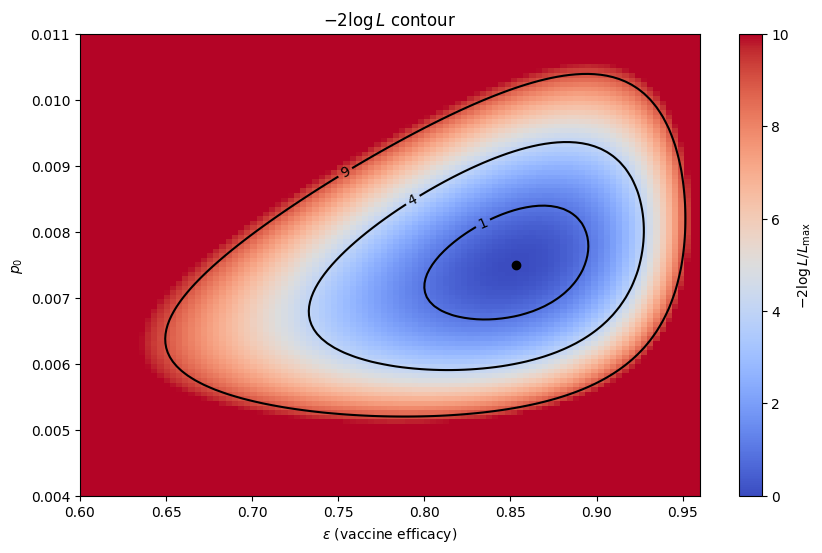

In [26]:
nptx, npty = 101, 101
x_p = np.linspace(0.60, 0.96, nptx)
y_p = np.linspace(0.004, 0.011, npty)
x, y = np.meshgrid(x_p, y_p)
f = lambda eff, p0: np.vectorize(neg_2log_likelihood)(i0, i1, eff, p0, n0, n1) - f_min
z = f(x, y)
figure, ax = plt.subplots(figsize=(10, 6))
col = ax.pcolormesh(x, y, z, cmap='coolwarm', vmin=0, vmax=10, shading='auto')
con = ax.contour(x, y, z, [1, 4, 9], colors='black')
ax.scatter([eff_ml], [p0_ml], color='black')
ax.clabel(con, inline=1, fontsize=10)
ax.set_title('$-2\log L$ contour')
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel(r"$\varepsilon$ (vaccine efficacy)")
ax.set_ylabel('$p_0$')
figure.colorbar(col, label='$-2\log L/L_{\mathrm{max}}$')
plt.show()

Confrontiamo con gli errori che abbiamo calcolato:

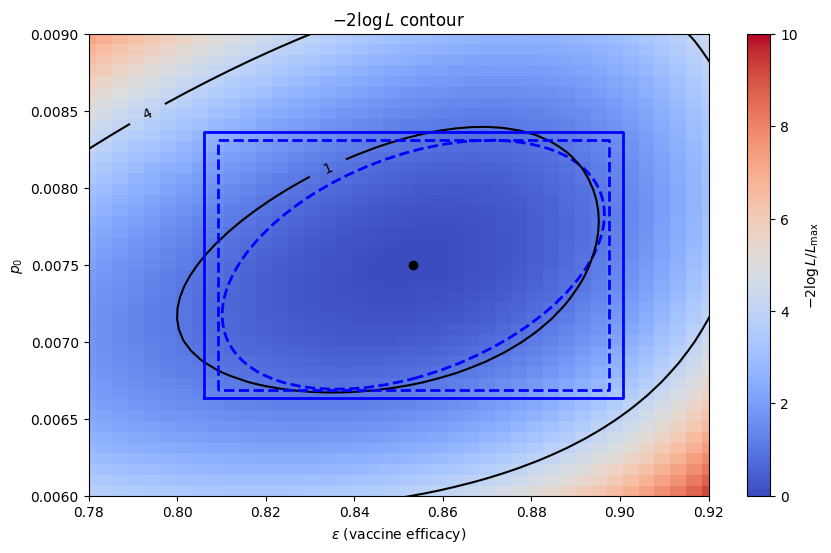

In [27]:
figure, ax = plt.subplots(figsize=(10, 6))
col = ax.pcolormesh(x, y, z, cmap='coolwarm', vmin=0, vmax=10, shading='auto')
con = ax.contour(x, y, z, [1, 4], colors='black')
ax.scatter([eff_ml], [p0_ml], color='black')
ax.clabel(con, inline=1, fontsize=10)
ax.set_title('$-2\log L$ contour')
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel(r"$\varepsilon$ (vaccine efficacy)")
ax.plot([eff_est - eff_err_ml, eff_est - eff_err_ml, eff_est + eff_err_ml, eff_est + eff_err_ml, eff_est - eff_err_ml],
        [p0_est - p0_err_ml, p0_est + p0_err_ml, p0_est + p0_err_ml, p0_est - p0_err_ml, p0_est - p0_err_ml], color='blue', linewidth=2, linestyle='--')
ax.plot([eff_est - eff_err, eff_est - eff_err, eff_est + eff_err, eff_est + eff_err, eff_est - eff_err],
        [p0_est - p0_err, p0_est + p0_err, p0_est + p0_err, p0_est - p0_err, p0_est - p0_err], color='blue', linewidth=2)
eig_val, eig_vec = np.linalg.eig(cov)
scale = math.sqrt(1 - rho**2)
e1, e2 = math.sqrt(eig_val[0])*scale, math.sqrt(eig_val[1])*scale
ell = patches.Ellipse((eff_est, p0_est), 2*e1, 2*e2, angle=phi_deg, linewidth=2, linestyle='--', color='blue', fill=False)
ax.add_patch(ell)
ax.set_ylabel('$p_0$')
ax.set_xlim(0.78, 0.92)
ax.set_ylim(0.006, 0.009)
figure.colorbar(col, label='$-2\log L/L_{\mathrm{max}}$')
plt.show()

Calcoliamo l'intervallo che corrisponde ad una variazione di $-2\log{\cal L}$ di +1. Questo ci fornirà una stima dell'errore migliore di quella con l'approssimazione gaussiana, assumendo però che $p_0$ sia fissato ed uguale al valore stimato $\hat{p}_0$:

In [28]:
def interval_ml(p0):
    if i1 == n1:
        x_lo = 0
    else:
        x_lo = scipy.optimize.root_scalar(lambda x:
            neg_2log_likelihood(i0, i1, x, p0, n0, n1) - f_min - 1, 
            method='bisect', bracket=(0.0, eff_ml), xtol=0.00000001).root
    if i1 == 0:
        x_hi = 1
    else:
        x_hi = scipy.optimize.root_scalar(lambda x:
            neg_2log_likelihood(i0, i1, x, p0, n0, n1) - f_min - 1, 
            method='bisect', bracket=(eff_ml, 0.9999999), xtol=0.00000001).root
    return x_lo, x_hi
e_min_ml, e_max_ml = interval_ml(p0_ml)
print('Int. max. lik.: ε[{:.3f}, {:.3f}]'.format(e_min_ml, e_max_ml))
print('ε = {:.3f} +{:.3f}/-{:.3f} (asym., p0 fixed)'.format(eff_ml, e_max_ml - eff_ml,eff_ml - e_min_ml))
print("ε = {:.3f} ±{:.3f} (p0, p1 err., sym.)".format(eff_est, eff_err))
print("ε = {:.3f} ±{:.3f} (m.l., sym.)".format(eff_est, eff_err_ml))

Int. max. lik.: ε[0.805, 0.893]
ε = 0.853 +0.040/-0.049 (asym., p0 fixed)
ε = 0.853 ±0.047 (p0, p1 err., sym.)
ε = 0.853 ±0.044 (m.l., sym.)


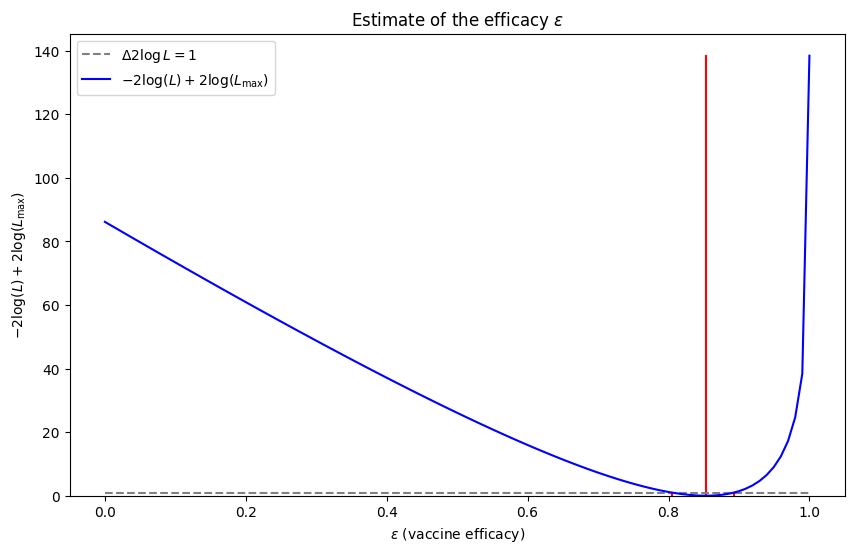

In [29]:
def plot_2logL(x_min, x_max):
    x_range = np.linspace(x_min, x_max, 100)
    ys = []
    for e in x_range:
        ys.append(neg_2log_likelihood(i0, i1, e, p0_ml, n0, n1))
    y_lik = np.array(ys) - f_min
    y_range = [0, np.max(y_lik)]
    plt.figure(figsize=(10, 6))
    plt.plot([eff_ml, eff_ml], y_range, color='red')
    plt.plot([x_min, x_max], [1, 1], label=r"$\Delta 2\log L = 1$", color='gray', linestyle='--')
    plt.plot([e_min_ml, e_min_ml], [0, 1], color='red')
    plt.plot([e_max_ml, e_max_ml], [0, 1], color='red')
    plt.plot(x_range, y_lik, label=r"$-2\log(L) + 2\log(L_{\mathrm{max}})$", color='blue')
    plt.title(r"Estimate of the efficacy $\varepsilon$")
    plt.xlabel(r"$\varepsilon$ (vaccine efficacy)")
    plt.ylabel(r"$-2\log(L) + 2\log (L_{\mathrm{max}})$")
    plt.legend()
    plt.ylim(0)
    plt.show()
plot_2logL(0, 1)

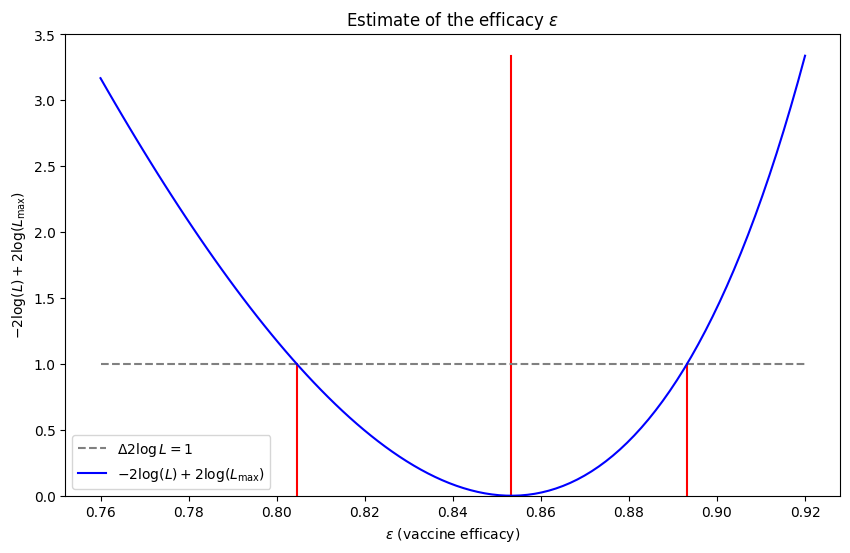

In [30]:
plot_2logL(0.76, 0.92)

Ripetiamo lo scan per diversi valori di $p_0$ intorno a $\hat{p}_0$:

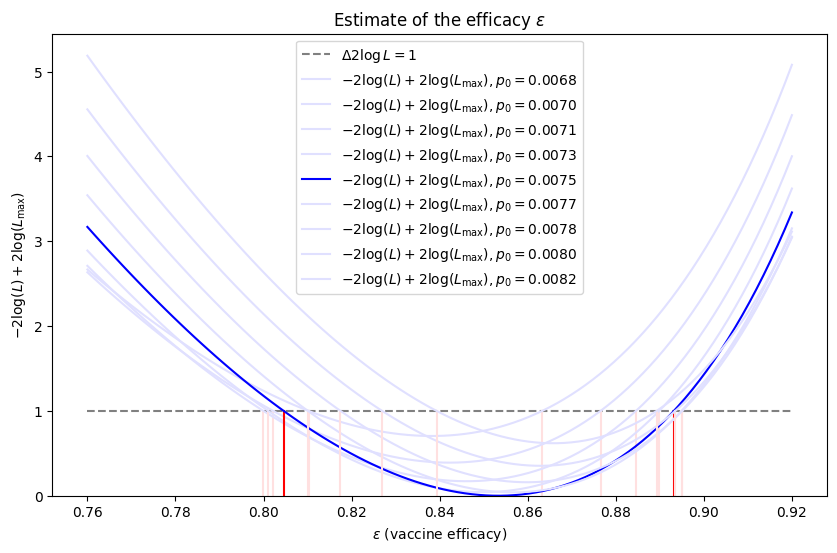

p0 fixed   : ε = 0.853 +0.040/-0.049 (asym.)
p0 variable: ε = 0.853 +0.042/-0.053 (asym.)


In [31]:
x_min, x_max = 0.76, 0.92
x_range = np.linspace(x_min, x_max, 100)
plt.figure(figsize=(10, 6))
plt.plot([x_min, x_max], [1, 1], label=r"$\Delta 2\log L = 1$", color='gray', linestyle='--')
e_min, e_max = 1, 0
for p0 in np.linspace(p0_ml - 0.0007, p0_ml + 0.0007, 9):
    ys = []
    for e in x_range:
        ys.append(neg_2log_likelihood(i0, i1, e, p0, n0, n1))
    y_lik = np.array(ys) - f_min
    y_range = [0, np.max(y_lik)]
    c_blue, c_red = ('blue', 'red') if p0==p0_ml else ('#e0e0ff', '#ffe0e0')
    int_ml = interval_ml(p0)
    plt.plot([int_ml[0], int_ml[0]], [0, 1], color=c_red)
    plt.plot([int_ml[1], int_ml[1]], [0, 1], color=c_red)
    plt.plot(x_range, y_lik, label=r"$-2\log(L) + 2\log(L_{\mathrm{max}}), p_0=" + "{:.4f}".format(p0) + "$", color=c_blue)
    if e_min > int_ml[0]: e_min = int_ml[0]
    if e_max < int_ml[1]: e_max = int_ml[1]
plt.title(r"Estimate of the efficacy $\varepsilon$")
plt.xlabel(r"$\varepsilon$ (vaccine efficacy)")
plt.ylabel(r"$-2\log(L) + 2\log (L_{\mathrm{max}})$")
plt.legend()
plt.ylim(0)
plt.show()
print('p0 fixed   : ε = {:.3f} +{:.3f}/-{:.3f} (asym.)'.format(eff_ml, e_max_ml - eff_ml,eff_ml - e_min_ml))
print('p0 variable: ε = {:.3f} +{:.3f}/-{:.3f} (asym.)'.format(eff_ml, e_max - eff_ml, eff_ml - e_min))

Se si tiene conto dell'errore sul parametro $p_0$ bisogna allargare l'errore sulla stima di $\varepsilon$.

In generale, si distinguoni i parametri in:
* parametri di interesse (*parameters of interest*): $\varepsilon$, in questo caso
* parametri perturbanti (*nuisance parameters*): $p_0$ nel nostro caso

Questo metodo equivale a trovare le linee tangenti alla curva di livello  $-2\log{\cal L}/{\cal L}_{\mathrm{max}} = 1$ nel grafico bidimensionale. 

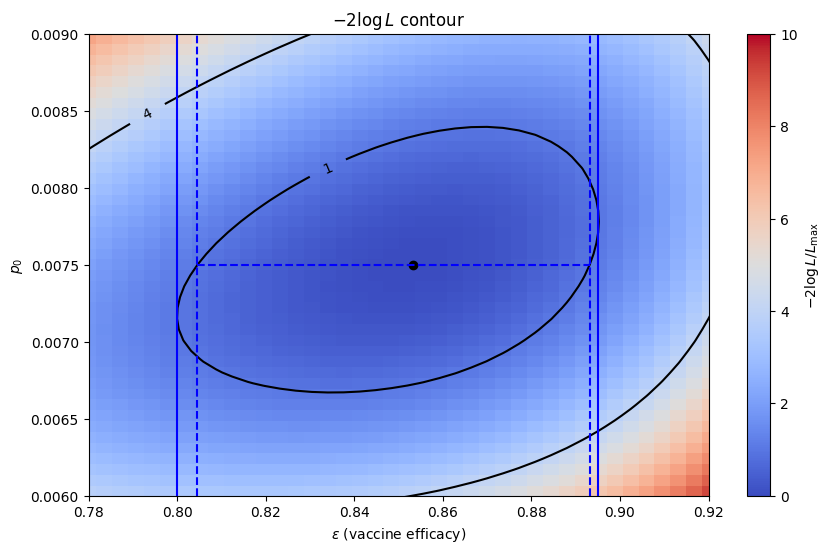

In [32]:
figure, ax = plt.subplots(figsize=(10, 6))
col = ax.pcolormesh(x, y, z, cmap='coolwarm', vmin=0, vmax=10, shading='auto')
con = ax.contour(x, y, z, [1, 4], colors='black')
ax.scatter([eff_ml], [p0_ml], color='black')
ax.clabel(con, inline=1, fontsize=10)
ax.set_title('$-2\log L$ contour')
ax.axis([x.min(), x.max(), y.min(), y.max()])
ax.set_xlabel(r"$\varepsilon$ (vaccine efficacy)")
ax.plot([e_max_ml, e_max_ml], [0.006, 0.009], color='blue', linestyle='--')
ax.plot([e_min_ml, e_min_ml], [0.006, 0.009], color='blue', linestyle='--')
ax.plot([e_min_ml, e_max_ml], [p0_est, p0_est], color='blue', linestyle='--')
ax.plot([e_max, e_max], [0.006, 0.009], color='blue')
ax.plot([e_min, e_min], [0.006, 0.009], color='blue')
ax.set_ylabel('$p_0$')
ax.set_xlim(0.78, 0.92)
ax.set_ylim(0.006, 0.009)
figure.colorbar(col, label='$-2\log L/L_{\mathrm{max}}$')
plt.show()